In [1]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as pl
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import keras.layers as kl
from bokeh.plotting import output_file, figure, show
import keras as kr
from sklearn.metrics import r2_score, mean_squared_error
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
fix.pdr_override()

In [3]:
class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data.to_csv("stock_data.csv")

    # get twitter data
    # do your code here!

    # get news data
    # do your code here!


if __name__ == "__main__":
    data = GetData("AAPL", "2000-01-01", "2018-10-01")
    data.get_stock_data()

[*********************100%***********************]  1 of 1 downloaded


In [4]:
class PreProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        self.stock_data = pd.read_csv("stock_data.csv")

    # wavelet transform and create autoencoder data
    def make_wavelet_train(self):
        train_data = []
        test_data = []
        log_train_data = []
        for i in range((len(self.stock_data)//10)*10 - 11):
            train = []
            log_ret = []
            for j in range(1, 6):
                x = np.array(self.stock_data.iloc[i: i + 11, j])
                (ca, cd) = pywt.dwt(x, "haar")
                cat = pywt.threshold(ca, np.std(ca), mode="soft")
                cdt = pywt.threshold(cd, np.std(cd), mode="soft")
                tx = pywt.idwt(cat, cdt, "haar")
                log = np.diff(np.log(tx))*100
                macd = np.mean(x[5:]) - np.mean(x)
                # ma = np.mean(x)
                sd = np.std(x)
                log_ret = np.append(log_ret, log)
                x_tech = np.append(macd*10, sd)
                train = np.append(train, x_tech)
            train_data.append(train)
            log_train_data.append(log_ret)
        trained = pd.DataFrame(train_data)
        trained.to_csv("preprocessing/indicators.csv")
        log_train = pd.DataFrame(log_train_data, index=None)
        log_train.to_csv("preprocessing/log_train.csv")
        # auto_train = pd.DataFrame(train_data[0:800])
        # auto_test = pd.DataFrame(train_data[801:1000])
        # auto_train.to_csv("auto_train.csv")
        # auto_test.to_csv("auto_test.csv")
        rbm_train = pd.DataFrame(log_train_data[0:int(self.split*self.feature_split*len(log_train_data))], index=None)
        rbm_train.to_csv("preprocessing/rbm_train.csv")
        rbm_test = pd.DataFrame(log_train_data[int(self.split*self.feature_split*len(log_train_data))+1:
                                               int(self.feature_split*len(log_train_data))])
        rbm_test.to_csv("preprocessing/rbm_test.csv")
        for i in range((len(self.stock_data) // 10) * 10 - 11):
            y = 100*np.log(self.stock_data.iloc[i + 11, 5] / self.stock_data.iloc[i + 10, 5])
            test_data.append(y)
        test = pd.DataFrame(test_data)
        test.to_csv("preprocessing/test_data.csv")

    def make_test_data(self):
        test_stock = []
        # stock_data_test = pd.read_csv("stock_data_test.csv", index_col=0)

        for i in range((len(self.stock_data) // 10) * 10 - 11):
            l = self.stock_data.iloc[i+11, 5]
            test_stock.append(l)
            test = pd.DataFrame(test_stock)
            test.to_csv("preprocessing/test_stock.csv")

        stock_test_data = np.array(test_stock)[int(self.feature_split*len(test_stock) +
                                               self.split*(1-self.feature_split)*len(test_stock)):]
        stock = pd.DataFrame(stock_test_data, index=None)
        stock.to_csv("stock_data_test.csv")

        # print(train_data[1:5])
        # print(test_data[1:5])
        # plt.plot(train_data[1])
        # plt.show()


if __name__ == "__main__":
    preprocess = PreProcessing(0.8, 0.25)
    preprocess.make_wavelet_train()
    preprocess.make_test_data()

In [5]:
class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")

        train = pd.read_csv("preprocessing/rbm_train.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, input_shape))

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=300)

        encoder.save("models/encoder.h5")

        test = pd.read_csv("preprocessing/rbm_test.csv", index_col=0)
        ntest = np.array(test)
        test_data = np.reshape(ntest, (len(ntest), 1, 55))

        print(autoencoder.evaluate(test_data, test_data))
        # pred = np.reshape(ntest[1], (1, 1, 75))
        # print(encoder.predict(pred))

        log_train = pd.read_csv("preprocessing/log_train.csv", index_col=0)
        coded_train = []
        for i in range(len(log_train)):
            data = np.array(log_train.iloc[i, :])
            values = np.reshape(data, (1, 1, 55))
            coded = encoder.predict(values)
            shaped = np.reshape(coded, (20,))
            coded_train.append(shaped)

        train_coded = pd.DataFrame(coded_train)
        train_coded.to_csv("features/autoencoded_data.csv")


if __name__ == "__main__":
    autoencoder = AutoEncoder(20)
    autoencoder.build_train_model(55, 40, 30, 30, 40)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
939/939 [==============================] - 2s 3ms/step - loss: 16.7415
Epoch 2/300
939/939 [==============================] - 0s 231us/step - loss: 16.5457
Epoch 3/300
939/939 [==============================] - 0s 232us/step - loss: 16.2399
Epoch 4/300
939/939 [==============================] - 0s 227us/step - loss: 15.9655
Epoch 5/300
939/939 [==============================] - 0s 228us/step - loss: 15.8137
Epoch 6/300
939/939 [==============================] - 0s 225us/step - loss: 15.7180
Epoch 7/300
939/939 [==============================] - 0s 375us/step - loss: 15.6372
Epoch 8/300
939/939 [==============================] - 0s 227us/step - loss: 15.5555
Epoch 9/300
939/939 [==============================] - 0s 231us/step - loss: 15.4973
Epoch 10/300
939/939 [==============================] - 0s 227us/step - loss: 15.4639
Epoch 11/300
939/939 [=========

939/939 [==============================] - 0s 227us/step - loss: 15.2743
Epoch 90/300
939/939 [==============================] - 0s 224us/step - loss: 15.2730
Epoch 91/300
939/939 [==============================] - 0s 229us/step - loss: 15.2724
Epoch 92/300
939/939 [==============================] - 0s 223us/step - loss: 15.2705
Epoch 93/300
939/939 [==============================] - 0s 225us/step - loss: 15.2700
Epoch 94/300
939/939 [==============================] - 0s 374us/step - loss: 15.2685
Epoch 95/300
939/939 [==============================] - 0s 226us/step - loss: 15.2679
Epoch 96/300
939/939 [==============================] - 0s 223us/step - loss: 15.2655
Epoch 97/300
939/939 [==============================] - 0s 223us/step - loss: 15.2709
Epoch 98/300
939/939 [==============================] - 0s 225us/step - loss: 15.2701
Epoch 99/300
939/939 [==============================] - 0s 226us/step - loss: 15.2705
Epoch 100/300
939/939 [==============================] - 0s 225us/s

939/939 [==============================] - 0s 276us/step - loss: 15.2294
Epoch 184/300
939/939 [==============================] - 0s 402us/step - loss: 15.2303
Epoch 185/300
939/939 [==============================] - 0s 249us/step - loss: 15.2313
Epoch 186/300
939/939 [==============================] - 0s 233us/step - loss: 15.2304
Epoch 187/300
939/939 [==============================] - 0s 312us/step - loss: 15.2293
Epoch 188/300
939/939 [==============================] - 0s 236us/step - loss: 15.2282
Epoch 189/300
939/939 [==============================] - 0s 230us/step - loss: 15.2281
Epoch 190/300
939/939 [==============================] - 0s 224us/step - loss: 15.2272
Epoch 191/300
939/939 [==============================] - 0s 246us/step - loss: 15.2273
Epoch 192/300
939/939 [==============================] - 0s 321us/step - loss: 15.2270
Epoch 193/300
939/939 [==============================] - 0s 386us/step - loss: 15.2258
Epoch 194/300
939/939 [==============================] - 

939/939 [==============================] - 0s 228us/step - loss: 15.2140
Epoch 278/300
939/939 [==============================] - 0s 224us/step - loss: 15.2134
Epoch 279/300
939/939 [==============================] - 0s 225us/step - loss: 15.2126
Epoch 280/300
939/939 [==============================] - 0s 354us/step - loss: 15.2123
Epoch 281/300
939/939 [==============================] - 0s 225us/step - loss: 15.2127
Epoch 282/300
939/939 [==============================] - 0s 228us/step - loss: 15.2126
Epoch 283/300
939/939 [==============================] - 0s 228us/step - loss: 15.2123
Epoch 284/300
939/939 [==============================] - 0s 225us/step - loss: 15.2129
Epoch 285/300
939/939 [==============================] - 0s 225us/step - loss: 15.2119
Epoch 286/300
939/939 [==============================] - 0s 225us/step - loss: 15.2114
Epoch 287/300
939/939 [==============================] - 0s 224us/step - loss: 15.2144
Epoch 288/300
939/939 [==============================] - 

In [6]:
class DataProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        # self.train = pd.read_csv("train_data.csv", index_col=0)
        # print(train.tail())
        self.test = pd.read_csv("preprocessing/test_data.csv", index_col=0)
        # print(test.tail())
        self.test_stock = pd.read_csv("preprocessing/test_stock.csv", index_col=0)
        # self.auto_train = pd.read_csv("features/autoencoded_corrected_data.csv", index_col=0)
        self.auto_train = pd.read_csv("features/autoencoded_data.csv", index_col=0)
        # auto_train.drop([0, 14, 16], axis=1, inplace=True)
        # auto_train.to_csv("autoencoded_corrected_data.csv", index=None)

    def make_train_data(self):
        train_data = np.array(self.auto_train)[int(self.feature_split*len(self.auto_train))+1:
                                               int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_data = pd.DataFrame(train_data, index=None)
        train_data.to_csv("features/autoencoded_train_data.csv")

    def make_test_data(self):
        test_data = np.array(self.auto_train)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                                  self.feature_split*len(self.auto_train)+1):]
        test_data = pd.DataFrame(test_data, index=None)
        test_data.to_csv("features/autoencoded_test_data.csv")
        
    def make_train_y(self):
        train_y = np.array(self.test)[int(self.feature_split*len(self.auto_train))+1:
                                      int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_y = pd.DataFrame(train_y, index=None)
        train_y.to_csv("features/autoencoded_train_y.csv")

    def make_test_y(self):
        test_y = np.array(self.test)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                         self.feature_split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y)
        test_y.to_csv("features/autoencoded_test_y.csv")

    def make_stock_train_y(self):
        test_y = np.array(self.test_stock)[int(self.feature_split*len(self.auto_train))+1:
                                           int((1-self.feature_split)*self.split*len(self.auto_train))]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_train_y.csv")

    def make_stock_test_y(self):
        test_y = np.array(self.test_stock)[int((1-self.feature_split)*self.split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_test_y.csv")


if __name__ == "__main__":
    process = DataProcessing(0.8, 0.25)
    process.make_test_data()
    process.make_train_data()
    process.make_train_y()
    process.make_test_y()

Epoch 1/5
1644/1644 [==============================] - 16s 10ms/step - loss: 6.6721 - mean_squared_error: 6.4310
Epoch 2/5
1644/1644 [==============================] - 1s 675us/step - loss: 6.6275 - mean_squared_error: 6.4240
Epoch 3/5
1644/1644 [==============================] - 1s 614us/step - loss: 6.6063 - mean_squared_error: 6.4180
Epoch 4/5
1644/1644 [==============================] - 1s 636us/step - loss: 6.5890 - mean_squared_error: 6.4124
Epoch 5/5
704/704 [==============================] - 4s 6ms/step
[2.128443430770527, 1.966795802116394]


/Users/mac/anaconda3/envs/AI-Test/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


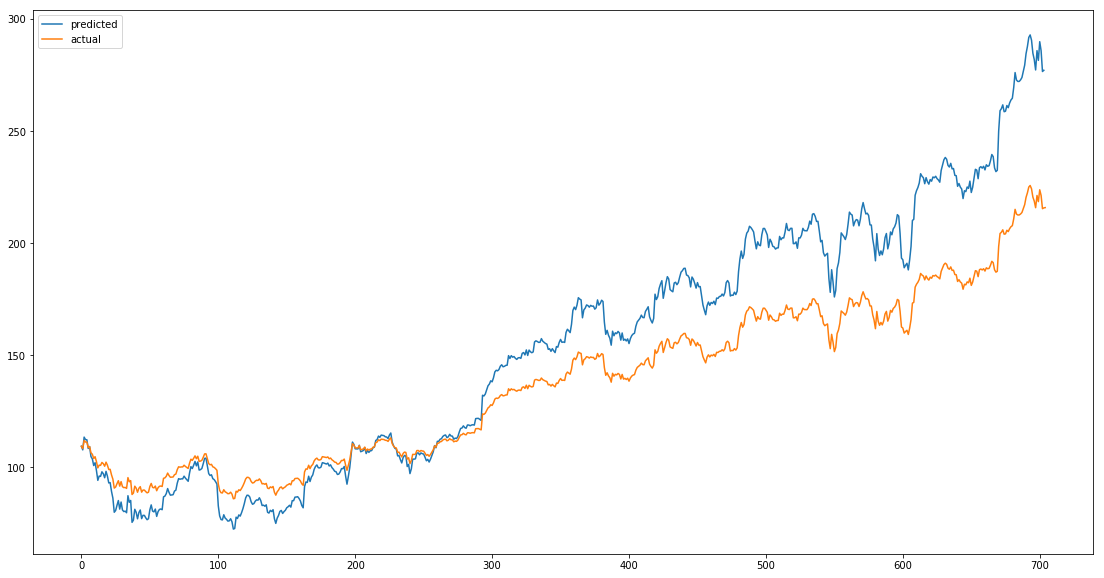

In [17]:
class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=5)

        model.save("models/model.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test.csv", index_col=0))

        print(model.evaluate(test_x, test_y))
        prediction_data = []
        stock_data = []
        for i in range(len(test_y)):
            prediction = (model.predict(np.reshape(test_x[i], (1, 1, self.input_shape))))
            prediction_data.append(np.reshape(prediction, (1,)))
            prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)
            stock_price = np.exp(np.reshape(prediction, (1,)))*stock_data_test[i]
            stock_data.append(stock_price[0])
        stock_data[:] = [i - (float(stock_data[0])-float(stock_data_test[0])) for i in stock_data]
        # stock_data = stock_data - stock_data[0]
        if self.stock_or_return:
            stock = pd.DataFrame(stock_data, index=None)
            stock.to_csv("sample_predictions/AAPL_predicted_prices.csv")
            stock_test = pd.DataFrame(stock_data_test, index=None)
            stock_test.to_csv("sample_predictions/AAPL_actual_prices.csv")
            data = {'AAPL_predicted_prices':[stock_data],'AAPL_actual_prices':[stock_data_test]}
            stock_diff = pd.DataFrame(data)
            stock_diff.to_csv("sample_predictions/AAPL_diff_prices.csv")
            
            
            plt.figure(1, figsize=(19, 10))
            plt.plot(stock_data)
            plt.plot(stock_data_test)
            # print(stock_data)
            plt.legend(['predicted','actual'])
            plt.show()
            
        else:
            # plt.plot(prediction_corrected)
            plt.plot(prediction_data)
            # print(prediction_data)
            plt.plot(test_y)
            plt.legend()
            plt.show()


if __name__ == "__main__":
    model = NeuralNetwork(20, True)
    model.make_train_model()


Epoch 1/5
1644/1644 [==============================] - 3s 2ms/step - loss: 51.6755
Epoch 2/5
1644/1644 [==============================] - 0s 198us/step - loss: 6.3297
Epoch 3/5
1644/1644 [==============================] - 0s 286us/step - loss: 6.3306
Epoch 4/5
1644/1644 [==============================] - 0s 160us/step - loss: 6.3294
Epoch 5/5
1644/1644 [==============================] - 0s 203us/step - loss: 6.3293


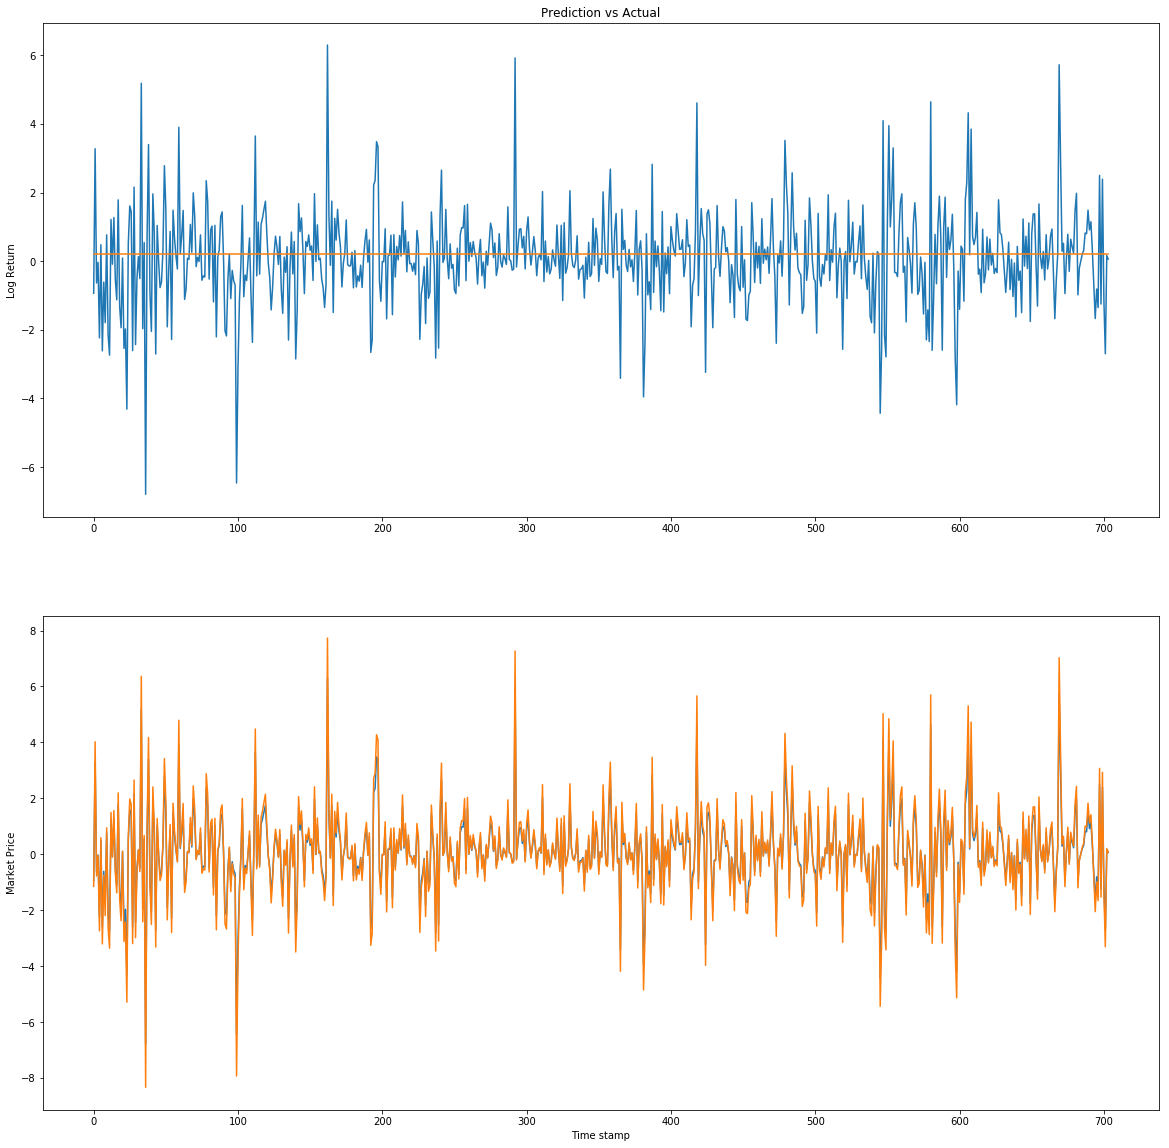

Regularizer for 1: 0.05 
Regularizer for 2: 0.01 
Epochs: 5
Predicted Price r^2 value: 0.965511876673405 
Predicted return r^2 value: -2082336384558011.2
Predict Price MSE: 0.09547671740395094 
Predicted Return MSE: 1.8494862393208076
[[0.19929706]]
Price Accuracy Average = -inf 
Price Accuracy Standard Deviation = nan


/Users/mac/anaconda3/envs/AI-Test/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/Users/mac/anaconda3/envs/AI-Test/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [8]:
def nnmodel(epochs, regularizer1, regularizer2):

    train_data = np.array(pd.read_csv("features/autoencoded_train_data.csv", index_col=0))
    # length = len(train_data)
    train_data = np.reshape(train_data, (len(train_data), 20))
    #print(np.shape(train_data))
    test_data = np.array(pd.read_csv("features/autoencoded_test_data.csv", index_col=0))
    test_data = np.reshape(test_data, (len(test_data), 20))
    train_y = np.array(pd.read_csv("features/autoencoded_train_y.csv", index_col=0))
    test_y = np.array(pd.read_csv("features/autoencoded_test_y.csv", index_col=0))
    price = np.array(pd.read_csv("features/autoencoded_test_y.csv", index_col=0))

    model = kr.models.Sequential()
    model.add(kl.Dense(20, input_dim=20, activation="relu", activity_regularizer=kr.regularizers.l2(regularizer1)))
    model.add(kl.Dense(40, activation="relu", activity_regularizer=kr.regularizers.l2(regularizer2)))
    model.add(kl.Dense(40, activation="relu", activity_regularizer=kr.regularizers.l2(regularizer2)))
    model.add(kl.Dense(20, activation="relu", activity_regularizer=kr.regularizers.l2(regularizer2)))
    model.add(kl.Dense(1))

    model.compile(optimizer="sgd", loss="mean_squared_error")
    model.fit(train_data, train_y, epochs=epochs)
    model.save("models/final_model.h5")
    predicted_data = []
    predicted_price = []
    for i in range(len(test_data)):
        prediction = model.predict(np.reshape(test_data[i], (1, 20)))
        predicted_data.append(prediction)
        price_pred = np.exp(prediction)*price[i]
        predicted_price.append(price_pred)
        #print(test_data[i])

    #print(model.evaluate(test_data, test_y))
    pd.DataFrame(np.reshape(predicted_price, (len(predicted_price, )))).to_csv("60_return_forex/predicted_price.csv")
    pd.DataFrame(price).to_csv("60_return_forex/price.csv")

    plt.figure(1, figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(predicted_data)), np.reshape(test_y, (len(test_y))),
             np.reshape(predicted_data, (len(predicted_data))))
    plt.title("Prediction vs Actual")
    plt.ylabel("Log Return")

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(predicted_price)), np.reshape(price, (len(price))),
             np.reshape(predicted_price, (len(predicted_price))))
    plt.xlabel("Time stamp")
    plt.ylabel("Market Price")
    plt.show()

    price_r_score = r2_score(np.reshape(predicted_price, (len(predicted_price))), price)
    return_r_score = r2_score(np.reshape(predicted_data, (len(predicted_data))), test_y)
    price_mse = mean_squared_error(np.reshape(predicted_price, (len(predicted_price))), price)
    return_mse = mean_squared_error(np.reshape(predicted_data, (len(predicted_data))), test_y)

    print(f"Regularizer for 1: {regularizer1} \nRegularizer for 2: {regularizer2} \nEpochs: {epochs}")
    print(f"Predicted Price r^2 value: {price_r_score} \nPredicted return r^2 value: {return_r_score}"
          f"\nPredict Price MSE: {price_mse} \nPredicted Return MSE: {return_mse}")
    dataset = []
    values = np.array([regularizer1, regularizer2, epochs, price_r_score, return_r_score, price_mse, return_mse])
    dataset.append(values)
    dataset = pd.DataFrame(dataset, columns=["regularizer1", "regularizer2", "epochs", "price_r_score", "return_r_score", "price_mse", "return_mse"])
    #print(dataset)
    accuracy = []
    for i in range(len(price)-1):
        acc = 100 - (np.abs(predicted_price[i] - price[i+1]))/price[i+1] * 100
        accuracy.append(acc)
    average = np.mean(accuracy)
    std = np.std(accuracy)
    ret_acc = []
    for i in range(len(test_y)-1):
        if test_y[i] != 0:
            acc = 100 - (np.abs(predicted_data[i] - test_y[i]))/test_y[i] * 100
            ret_acc.append(acc)
    ret_avg = np.mean(ret_acc)
    ret_std = np.std(ret_acc)
    pd.DataFrame(np.reshape(ret_acc, (len(ret_acc, )))).to_csv("60_return_forex/ret_acc.csv")
    prediction = np.exp(model.predict(np.reshape(test_data[-2], (1, 20))))*price[-2]
    print(prediction)

    return dataset, average, std


if __name__ == "__main__":
    dataset, average, std = nnmodel(5, 0.05, 0.01)
    print(f"Price Accuracy Average = {average} \nPrice Accuracy Standard Deviation = {std}")